### Auto Regression (AR)

- It is mainly a **Regression** where we multiply the inputs with some weights and get an output as a continuous value.
- It is called **Auto Regression** because here the inputs will be the previous values of the time series itself.

#### Here using `Auto Regression` we will predict future temperature of some date

In [1]:
# importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.ar_model import AutoReg

In [10]:
# loading the dataset

df = pd.read_csv("data/min_temp.csv", index_col=0, parse_dates=True)
X = df.values
print("Shape of data \t", df.shape)
print("_"*50)
print("Original Dataset:\n\n", df.head())
print("_"*50)
print("After extracting only temperature:\n\n", X)

Shape of data 	 (3650, 1)
__________________________________________________
Original Dataset:

             Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8
__________________________________________________
After extracting only temperature:

 [[20.7]
 [17.9]
 [18.8]
 ...
 [13.5]
 [15.7]
 [13. ]]


- Now on the basis of the previous temperature we will predict the future temperature.

#### Checking for `stationarity`

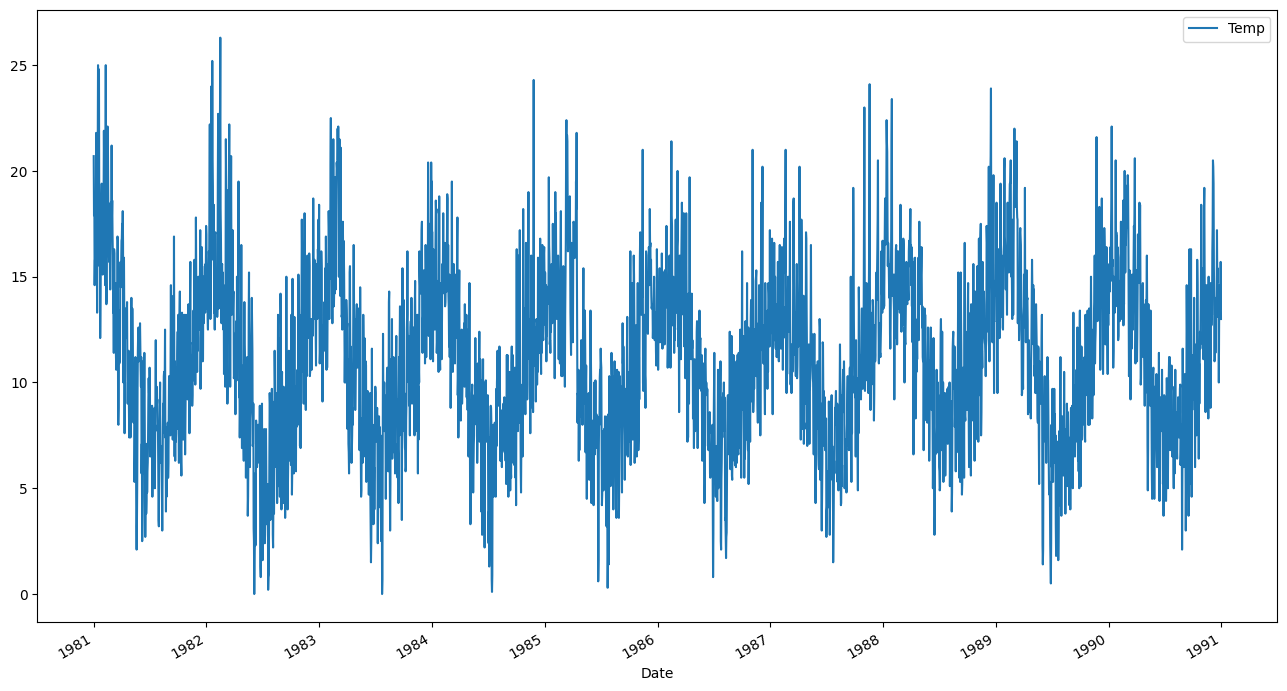

In [12]:
df.plot(figsize=(16,9))
plt.show()

**Notes**

The data looks `stationary`.

But here the plot looks `stationary` because it is a compressed view.


If we take selected value we can see that the plot will change.

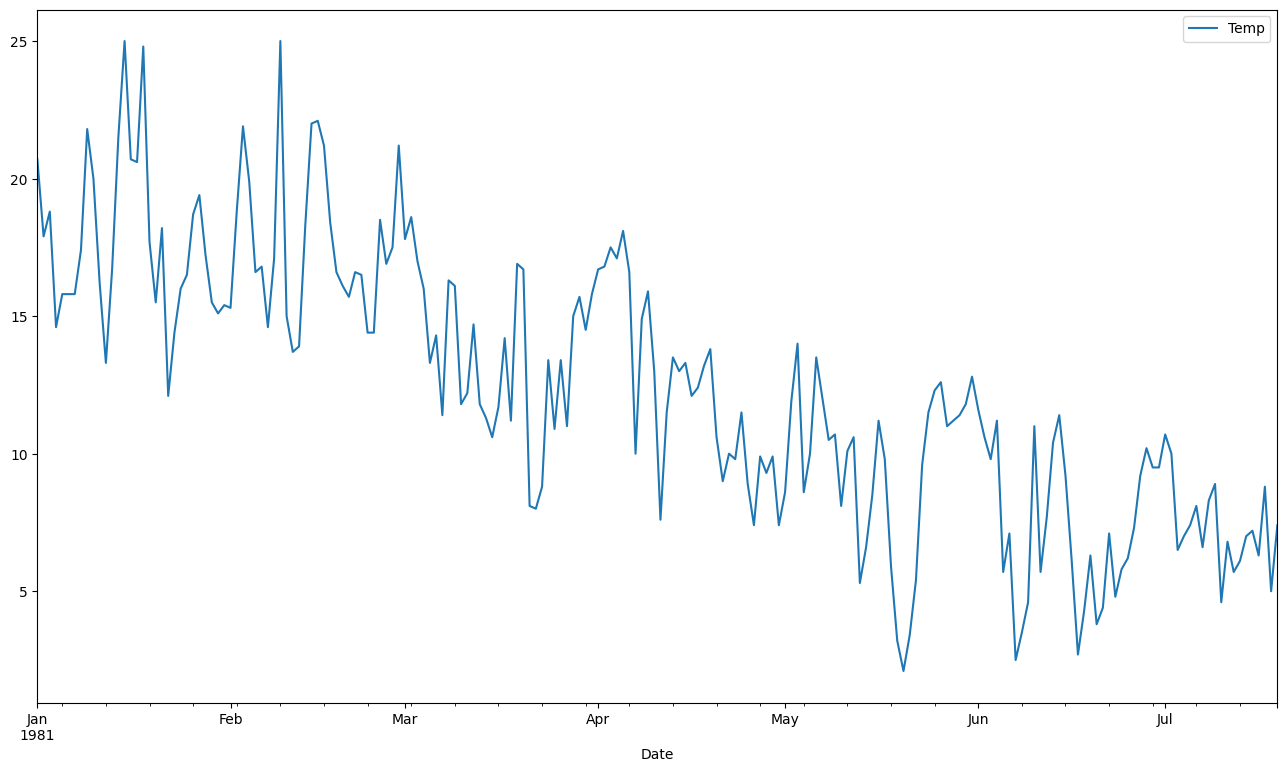

In [15]:
# plotting only 1st 200 values

df[:200].plot(figsize=(16,9))
plt.show()

**Notes**

- Now the data is not looking `stationary`.
- So it is better to do a statistical test




**Checking `stationarity` using statistical tests**

In [13]:
# Doing Augment Dickey Fuller test

from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [14]:
adf_test(df['Temp'])

1. ADF :  -4.444804924611675
2. P-Value :  0.0002470826300361248
3. Num Of Lags :  20
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 3629
5. Critical Values :
	 1% :  -3.4321532327220154
	 5% :  -2.862336767636517
	 10% :  -2.56719413172842


**Notes:**

As here we can see the `P-value` is very small, so the data is `stationary`.

- **Now we need to find out how many past values we should consider to predict the future value**.
- **For this we will need to use `AutoCorrelation`**.
- **Here specifically we will use `Partial AutoCorrelation`**.

C:\Users\Arun\anaconda3\envs\dsc\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


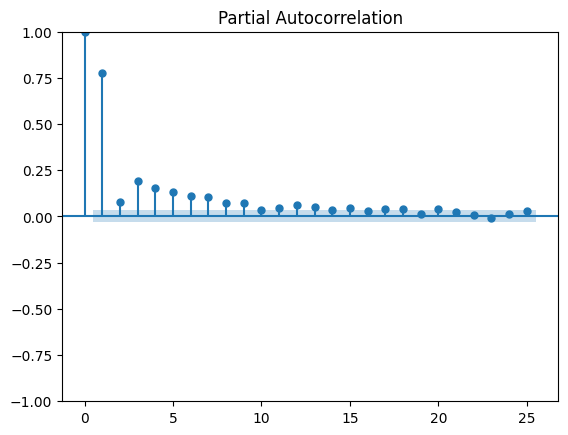

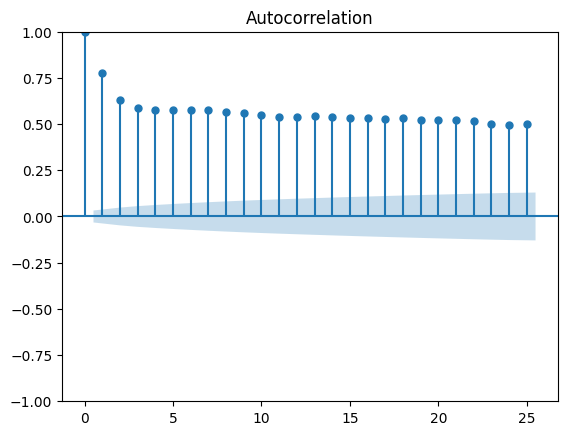

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Here we will have 25 lags

pacf = plot_pacf(df['Temp'], lags=25)
acf = plot_acf(df['Temp'], lags=25)

**Notes:**

- In `ACF` we can see high correlation upto `25th` lag. 
- So we need to see the `PACF` for `Auto Regression`. As it will only measure the direct effect of the previous time period on the current time period.
- In `PACF` we can see decent correlation upto `10th` lag.
- So we can consider `10` as lag to create a model and train it.

**splitting dataset into `train` and `test` data: keeping last `7` days as `test` data**

In [17]:
train = X[:len(X)-7]
test = X[len(X)-7:]

In [18]:
train.shape, test.shape

((3643, 1), (7, 1))

#### Now creating model and training it

In [19]:
model = AutoReg(train, lags=10).fit()
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 3643
Model:                    AutoReg(10)   Log Likelihood               -8375.514
Method:               Conditional MLE   S.D. of innovations              2.427
Date:                Mon, 16 Jan 2023   AIC                          16775.028
Time:                        21:00:27   BIC                          16849.402
Sample:                            10   HQIC                         16801.521
                                 3643                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9350      0.142      6.603      0.000       0.657       1.213
y.L1           0.6103      0.017     36.795      0.000       0.578       0.643
y.L2          -0.0832      0.019     -4.289      0.0

**Now making prediction**

In [20]:
# Here we are using 'dynamic=False'

pred = model.predict(start=len(train), end=len(X)-1, dynamic=False)
print(pred)

[11.47679312 12.63726604 13.0574664  13.03378918 12.8259307  12.65767226
 12.43273596]


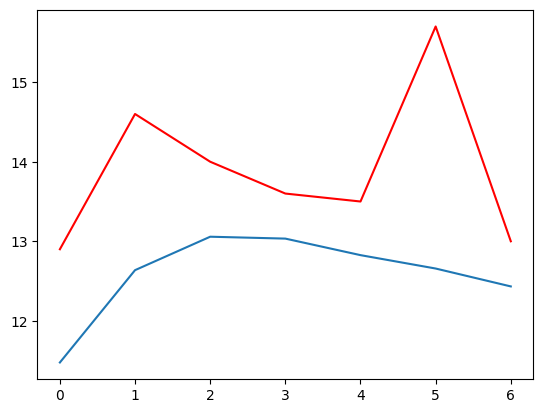

In [22]:
# Now plotting

plt.plot(pred)
plt.plot(test, color="red")
plt.show()

**Notes:**

- Here the model is not completely correct.

#### Calculating `Error`

In [23]:
# using root mean square

from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test, pred))
print(rmse)

1.5638196220860847


**Making future predictions**

In [24]:
# predicting for the next week after the date in dataset ends

pred_future = model.predict(start=len(X)+1, end=len(X)+7, dynamic=False)
print("The prediction for the next week will be:")
print(pred_future)
print("Number of Predictions made:\t", len(pred_future))

The prediction for the next week will be:
[12.28608804 12.20309536 12.24915916 12.30618875 12.31199689 12.27225975
 12.21843712]
Number of Predictions made:	 7
